##Лабораторная работа №3. Линейные модели


Лабораторная работа состоит из трёх частей, в каждой из которых вам нужно построить регерссионную модель и исследовать её свойства.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%matplotlib inline
np.random.seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Парная регрессия

В первой части вам нужно при помощи библиотеки NumPy сгенерировать данные и построить по ним уравнение парной линейной регерессии. Для генерации данных вам нужно определить значения параметров регрессионной модели $k$ и $b$, а также размер выбоки $n$. Устанавливаемые вами значения $k$ и $b$ можно считать «истинными» значениями генеральной совокупности.

In [0]:
k = np.random.normal() * 34
b = np.random.normal() * 20
n = 100

Теперь можно сгенерировать значения фактора $x$, воспользовавшись функцией `np.random.normal`, а затем вычислить значения целевой переменной $y$ как $y = kx + b + \epsilon$, где $\epsilon$ – случайное отклонение, для генерации которого также можно воспользоваться функцией `np.random.normal`.

In [0]:
X = np.random.normal(size=n)
y = (k * X + b) + np.random.normal(size=n) * 5

Постройте диаграмму рассеяния данных (поле корреляции). Для этого можно воспользоваться функцией [scatter](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html) библиотеки matplotlib.

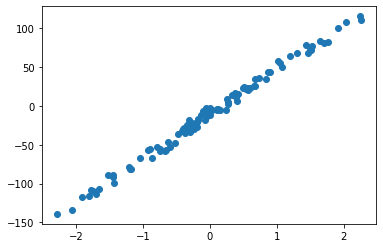

In [4]:
plt.scatter(X,y)

Вычислите ковариацию. Не используйте встроенную функцию `np.cov`, вычислите по формуле выборочной ковариации.

In [5]:
# cov = ((X - (X / n).sum()) * (y - (y / n).sum()) / n).sum()
cov = (X * y / n).sum() - (X / n).sum() * (y / n).sum() # Так удобнее
print("COV(X, Y) = {:.2f}".format(cov))

COV(X, Y) = 58.16


Вычислите коэффициент корреляции Пирсона $r_{xy}$. Не используйте встроенную функцию `np.corrcoef`. Вычислите по формуле, используя полученное на предыдущем шаге значение ковариации.

*Подсказка: для вычисления стандартного отклонения можно воспользоваться функцией `np.std`, но будьте осторожны, обратите внимание на параметр `ddof`.*

In [6]:
corr = cov / (X.std(ddof=1) * y.std(ddof=1))
print("Corr(X, Y) = {:.2f}".format(corr))

Corr(X, Y) = 0.99


Вычислите оценки параметров регрессии с использованием МНК. 

*Подсказка: Вычисление оценок параметров регресси сводится к решению системы $X^T X P = X^T Y$, где $P$ - вектор-столбец искомых параметров. Для решения системы можно использовать функции `np.linalg.inv` и `np.linalg.solve`.*

In [7]:
tX = X[:, np.newaxis]
tX = np.c_[X, np.ones(n)]
Xt = tX.transpose()
p = np.linalg.solve(Xt.dot(tX), Xt.dot(y))
print(p)
print(k,b)

[57.24425302 -9.66882151]
57.47787392921211 -9.318747410816655


Вычислите коэффициент детерминации $R^2$, воспользовавшись двумя формулами: как квадрат коэффициента корреляции и через отношение остаточной дисперсии к общей дисперсии целевой переменной.

In [8]:
rs1 = corr**2
rs2 = 1 - (X.var(ddof=1) / y.var(ddof=1))

print(rs1, rs2, sep='\n')

0.9731719591454406
0.9996969910808721


Постройте линию регрессии на поле корреляции. 

*Подсказка: для построения линии можно воспользоваться функцией [plot](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.plot.html) библиотеки matplotlib.*

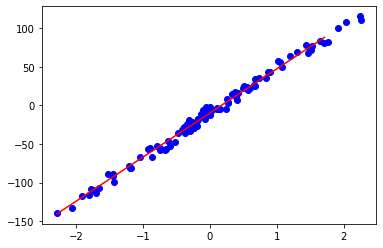

In [9]:
plt.plot(X, y, 'bo')
plt.plot(np.arange(X.min(),X.max()) ,p[0]*np.arange(X.min(),X.max())+p[1], 'red')

Вычислите [среднюю ошибку аппроксимации](http://univer-nn.ru/ekonometrika/koefficient-korrelyacii-srednyaya-oshibka-approksimacii-koefficient-elastichnosti/). Эта величина показывает, на сколько процентов в среднем расчётное значение целевой переменной отличается от фактического.

In [10]:
a = np.abs((y - (p[0]*X+p[1])) / y).sum() / n
print("Средняя ошибка аппроксимации: {:.2f} %".format(a))

Средняя ошибка аппроксимации: 0.27 %


Оцените статистическую значимость уравнения регресии при помощи F-критерия. Для вычисления значения F-критерия вы можете воспользоваться формулой $F = \frac{SSM}{SSE} \frac{n-k-1}{k}$, где $n$ – количество наблюдений в выборке, $k$ – количество факторов, включенных в модель (для парной регрессии $k=1$). Используйте значение уровня значимости $\alpha = 0,05$.

*Подсказка: для вычисления $P(X > F)$ можно воспользоваться функцией [`scipy.stats.f.sf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html) библиоткеки scipy.*

In [11]:
yp = p[0]*np.arange(n)+p[1]
xp = np.arange(n)
ssm = ((yp - (y / n).sum())**2).sum()
sse = ((y-yp)**2).sum()
F = ssm/sse * (n-2)
print(F, stats.f.sf(F, n, n) < 0.05)

98.17721912122552 True


Вычислите стандартную ошибку коэффициента регресии и оцените его статистическую значимость при помощи t-критерия Стьюдента. Используйте значение уровня значимости $\alpha = 0,05$.

*Подсказка: стандартная ошибка $s_k$ коэффициента регрессии $k$ может быть найдена по формуле $s_k = \frac{\sigma_{ост}}{\sigma_x \sqrt{n - 1}}$ (формула 3.49 в [2]), а значение статистики $t = \frac{k}{s_k}$. Для вычисления $P(X > |t|)$ можно воспользоваться функцией [`scipy.stats.t.sf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html) библиоткеки scipy. При использовании `np.std` обратите внимание на параметр `ddof`.*

In [12]:
sk = xp.std(ddof=1)/(X.std(ddof=1)* ((n-1)**1/2)) # В общем я не понял что такое sigma ост
t = 1 / sk
print(t, stats.t.sf(t, n, n))

1.7285441206354608 1.0


Удостоверьтесь в правильности проведённых вычислений, проведя повторные рассчёты с помощью бибилиотеки [statsmodels](https://www.statsmodels.org/stable/index.html).


В результате вы должны получить примерно следующее.
```
OLS Regression Results                            
==============================================================================================
Dep. Variable:                      y   R-squared:                       **0.855**
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     **578.9**
Date:                Wed, 08 Apr 2020   Prob (F-statistic):              **6.52e-43**
Time:                        20:18:48   Log-Likelihood:                -180.77
No. Observations:                 100   AIC:                             365.5
Df Residuals:                      98   BIC:                             370.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                 coef          std err          t            P>|t|          [0.025      0.975]
------------------------------------------------------------------------------
x1             **0.7023**      **0.029**     **24.060**      **0.000**       0.644       0.760
const          **5.0939**      0.316           16.106        0.000           4.466       5.722
==============================================================================================
Omnibus:                        5.958   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.479
Skew:                           0.057   Prob(JB):                      0.00874
Kurtosis:                       4.504   Cond. No.                         23.1
==============================================================================================
```

Значения, которые должны совпасть с вычисленными вами, помечены символами `**`.

In [13]:
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              2818.
Date:                Sat, 16 May 2020   Prob (F-statistic):                    1.52e-74
Time:                        10:20:31   Log-Likelihood:                         -380.08
No. Observations:                 100   AIC:                                      762.2
Df Residuals:                      99   BIC:                                      764.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 2. Множественная регрессия

Во второй части вам нужно построить модель множественной линейной регрессии, позволяющую предсказать процент бедного населения в регионе по набору социально-экономических показателей. Для построения модели предлагается использовать данные для 50 штатов США и округа Колумбия. В данных представлены следующие показатели.


1.   Процент населения, проживающего в крупных городах (metro_res).
2.   Процент населения европейского происхождения (white).
3. Процент людей со средним образованием (hs_grad).
4. Процент бедного населения (poverty).
5. Процент семей, в которых женщина является домохозяйкой (female_house).



In [14]:
df = pd.read_csv('http://d396qusza40orc.cloudfront.net/statistics/lec_resources/states.csv')
df.shape

(51, 6)

In [15]:
df.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.4,71.3,79.9,14.6,14.2
1,Alaska,65.6,70.8,90.6,8.3,10.8
2,Arizona,88.2,87.7,83.8,13.3,11.1
3,Arkansas,52.5,81.0,80.9,18.0,12.1
4,California,94.4,77.5,81.1,12.8,12.6


Выполните проверку данных на мультиколлинеарность. Постройте матрицу корреляции. На основе анализа матрицы корреляции определите, какие факторы нужно включить в регрессионную модель.

*Подсказка: для построения матрицы корреляции можно использовать функцию `pd.DataFrame.corr`.*

In [16]:
corr_matrix = df.corr()
corr_matrix

,metro_res,white,hs_grad,poverty,female_house
metro_res,1.000000,-0.342442,0.018110,-0.204235,0.300062
white,-0.342442,1.000000,0.238156,-0.308520,-0.751394
hs_grad,0.018110,0.238156,1.000000,-0.746858,-0.611867
poverty,-0.204235,-0.308520,-0.746858,1.000000,0.525397
female_house,0.300062,-0.751394,-0.611867,0.525397,1.000000


<Figure size 1440x1440 with 0 Axes>

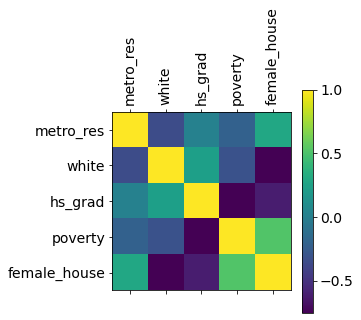

In [17]:
plt.figure(figsize=(20, 20))
plt.matshow(corr_matrix)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14, rotation=90)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

Вычислите оценки параметров модели при помощи МНК.

In [18]:
X =  df.loc[:,['metro_res', 'white', 'hs_grad', 'female_house']]
y = df.loc[:,'poverty']
model = LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Вычислите [скорректированный коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8#%D0%A1%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B9_(adjusted)_'%22%60UNIQ--postMath-00000015-QINU%60%22') полученной регрессионной модели.

*Подсказка: скорректированный коэффициент детерминации можно вычислить по формуле $R^2_{adj} = 1 - \frac{SSE}{SST} \frac{n - 1}{n - k - 1}$.*

In [19]:
r2_score(y, model.predict(X))

0.6415759298804308

При помощи F-критерия оцените статистическую значимость уравнения регрессии. Используйте значение уровня значимости $\alpha = 0,05$.

In [20]:
model_y = np.array(model.predict(X))
sse = np.sum(np.square(y - model_y))
ssm = np.sum(np.square(model_y - np.average(y)))
F = (ssm/sse)*((y.shape[0]-X.shape[1]-1)/X.shape[1])
print(F, stats.f.sf(F, n, n),stats.f.sf(F, n, n) < 0.05)

20.584898751815498 1.0152626723410643e-39 True


Удостоверьтесь в правильности проведённых вычислений, проведя повторные рассчёты с помощью бибилиотеки [statsmodels](https://www.statsmodels.org/stable/index.html).

In [21]:
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                poverty   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              287.8
Date:                Sat, 16 May 2020   Prob (F-statistic):                    2.09e-32
Time:                        10:20:36   Log-Likelihood:                         -115.47
No. Observations:                  51   AIC:                                      238.9
Df Residuals:                      47   BIC:                                      246.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

На основе анализа значений t-статистики, полученных на предыдущем шаге, определите, коэффициенты при каких факторах статистически значимо отклоняются от нуля.

hs_grad

## 3. Полиномиальная регрессия

В третьей части вам нужно построить регрессионную модель, в которой зависимость $y$ от $x$ имеет нелинейный характер. 

In [0]:
df = pd.read_csv('http://edu.std-900.ist.mospolytech.ru/files/nonlinear_data.csv')
x, y = df.x.values, df.y.values

Постройте диаграмму рассеяния для загруженных данных.

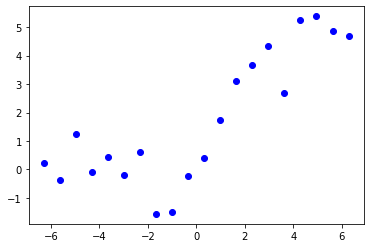

In [23]:
plt.plot(x, y, 'bo')

Вычислите оценки параметров регрессионных моделей с помощью МНК для полиномов степеней 1-15. Постройте графики получившихся кривых. Наблюдаются ли на графике сильно выраженные осцилляции (колебания)? Если наблюдаются, то начиная с какой степени полинома?

*Подсказка: в библиотеке `sklearn` есть удобный класс [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), который позволяет легко подготовить данные для построения полиномиальной регрессии.*

In [0]:
colors = [('#%06X' % np.random.randint(0, 0xFFFFFF)) for i in range(16)]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.84042e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.22818e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.79914e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.14027e-22): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4544e-23): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlg

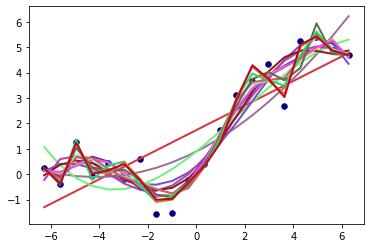

In [27]:
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")
result = []
for i in range(1,16):
  poly = make_pipeline(PolynomialFeatures(degree=i), Ridge())
  poly.fit(x.reshape(-1, 1), y.reshape(-1, 1))
  y_plot = poly.predict(x.reshape(-1, 1))
  plt.plot(x, y_plot, color=colors[i], linewidth=2,
             label="degree %d" % i)
  result.append((i, r2_score(y, y_plot)))
# i = 5
# poly = make_pipeline(PolynomialFeatures(degree=i), Ridge())
# poly.fit(x.reshape(-1, 1), y.reshape(-1, 1))
# y_plot = poly.predict(x.reshape(-1, 1))
# plt.plot(x, y_plot, color=colors[i], linewidth=2,
#             label="degree %d" % i)

Наблюдаются с 7й степени стремление пройти через точки данных обучения (те он просто выучит их), 1я степень - линия

Полином какой степени, по вашему мнению, наилучшим образом описывает данные? Вычислите для него коэффициент детерминации.

In [28]:
print(result)

[(1, 0.6715328042693787), (2, 0.7827964873020049), (3, 0.8298750928581241), (4, 0.8846629719496358), (5, 0.8975857950543864), (6, 0.9023196469417206), (7, 0.9232101802437395), (8, 0.924494470256858), (9, 0.926616944005615), (10, 0.9452752768808246), (11, 0.9434968464012019), (12, 0.9508472811305665), (13, 0.9607992096154588), (14, 0.9696328699057948), (15, 0.9708364021887155)]


Полином 6 степени

## Полезные материалы


1.   [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)
2.   Фёрстер Э. Методы корреляционного и регрессионного анализа. Руководство для экономистов. / Э. Фёрстер, Б. М. Рёнц – М.: «Финансы и статистика», 1983 г. – 304 с.


